# Векторные репрезентации слов и документов
# Часть 3. Тематическое моделирование (topic modeling)
## Оглавление
* Латентное размещение Дирихле (LDA)
* LDA & Word2vec

---
## Введение
[Тематическое моделирование](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C) — способ построения модели коллекции
текстовых документов, которая определяет, к каким темам относится каждый из
документов. Переход из пространства терминов в пространство найденных тематик помогает разрешать синонимию и полисемию терминов.

Cжатое семантическое описание слова или документа представляет собой вероятностное распределение на множестве тем.

Тематическое моделирование позволяет автоматически систематизировать и реферировать электронные архивы такого масштаба, который человек не в силах обработать.

**Иллюстрация идеи**
![Topic modeling](http://kldavenport.com/wp-content/uploads/2017/03/Blei-lda-2011-940x457.png)


**[Карпович]** *Тематические модели задают мягкую кластеризацию* слов и документов по кластерам-темам, означающую, что слово или документ могут быть отнесены сразу нескольким темам с различными вероятностями.
В результате синонимы с большой вероятностью будут отнесены к одной теме, так как часто употребляются в рамках одних и тех же контекстов, а омонимы попадут в разные, так как их контексты различаются. Тематические модели, как правило, основаны на гипотезе «мешка слов» и «мешка документов», т.е. порядок документов в коллекции не имеет значения и порядок слов в документе не имеет значения.



**Необходимые библиотеки**

In [1]:
%env MKL_DYNAMIC=FALSE
%env MKL_NUM_THREADS=8

import os
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import numpy as np
import scipy.sparse as sparse

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.phrases import Phrases
from gensim.models import word2vec

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', None)
pd.set_option('display.mpl_style', 'default')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

sns.set_style('whitegrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
rc={"lines.linewidth": 1.5})

from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
%matplotlib inline

env: MKL_DYNAMIC=FALSE
env: MKL_NUM_THREADS=8


## Загрузка данных

In [46]:
path_data = '~/'
file = path_data + 'corpora_lem.csv'

arxiv_id = pd.read_csv(path_data + 'corpora_lem.csv', chunksize=1, usecols=['arxiv_id'])
n_corpora = len([_id for _id in arxiv_id])
print("Corpora size: %d" % n_corpora)

Corpora size: 164197


Сериализация python-объектов

In [2]:
def pickling_data(name, data):
    out = open(name + '.pkl', 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [48]:
class LazyCorpora:
    def __init__(self, file, limit=1000, column=False):
        self.file = file
        self.limit = limit
        self.column = column
    
    def __iter__(self):
        chunks = pd.read_csv(self.file, iterator=True, encoding = "ISO-8859-1")
        for i in range(self.limit):
            row = chunks.read(1)
            content = row['text'].values[0].split()
            cleaned = [token for token in content if token[0] in 'abcdefghijklmnopqrstuvwxyz' and token not in stop]
            condition = len(cleaned) < 15000
            if condition:
                if not self.column:
                    yield cleaned
                else:
                    yield row[self.column].values[0]

In [5]:
documents = LazyCorpora(file)
dictionary = gensim.corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

In [6]:
for doc in documents:
    print(doc[:100])
    break

['goal', 'paper', 'construct', 'invariant', 'dynamical', 'object', 'necessarily', 'invertible', 'smooth', 'self', 'map', 'compact', 'manifold', 'prove', 'result', 'take', 'advantage', 'difference', 'rat', 'expansion', 'term', 'sheaf', 'cohomological', 'long', 'exact', 'sequence', 'create', 'unique', 'lift', 'finite', 'dimensional', 'invariant', 'subspace', 'one', 'term', 'sequence', 'invariant', 'subspace', 'precede', 'term', 'allow', 'take', 'invariant', 'cohomological', 'class', 'right', 'circumstance', 'construct', 'unique', 'current', 'give', 'type', 'include', 'unique', 'measure', 'give', 'type', 'represent', 'class', 'invariant', 'pullback', 'dynamically', 'interest', 'self', 'map', 'may', 'plethora', 'invariant', 'measure', 'uniquess', 'construct', 'current', 'important', 'mean', 'local', 'growth', 'big', 'compare', 'growth', 'rate', 'cohomological', 'class', 'expand', 'cohomological', 'class', 'give', 'sufficient', 'march', 'order', 'invariant', 'current', 'type', 'say', 'local

## Латентное размещение Дирихле
[Описание]  

![lda](http://hellomarc.us/static/images/lda-plate.png)

>**Количество классов в корпусе = 26**

In [8]:
%%time

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=50, update_every=1, chunksize=100, passes=1)

CPU times: user 56.9 s, sys: 1min 43s, total: 2min 40s
Wall time: 41.1 s


In [9]:
lda.print_topics(10, num_words=20)

[(2,
  '0.029*"measure" + 0.021*"map" + 0.016*"let" + 0.013*"set" + 0.012*"theorem" + 0.010*"system" + 0.010*"follow" + 0.010*"give" + 0.009*"markov" + 0.009*"ergodic" + 0.008*"use" + 0.008*"prove" + 0.008*"time" + 0.008*"result" + 0.008*"function" + 0.007*"mix" + 0.007*"lemma" + 0.006*"section" + 0.006*"proposition" + 0.006*"define"'),
 (18,
  '0.054*"de" + 0.047*"digraph" + 0.040*"le" + 0.025*"et" + 0.024*"la" + 0.022*"command" + 0.017*"environment" + 0.016*"que" + 0.015*"est" + 0.015*"balance" + 0.014*"dans" + 0.012*"un" + 0.012*"pour" + 0.011*"si" + 0.010*"par" + 0.010*"nous" + 0.009*"en" + 0.009*"une" + 0.006*"ce" + 0.006*"tout"'),
 (15,
  '0.027*"let" + 0.019*"flow" + 0.015*"follow" + 0.015*"close" + 0.013*"constant" + 0.013*"measure" + 0.013*"current" + 0.013*"positive" + 0.011*"smooth" + 0.011*"theorem" + 0.011*"function" + 0.010*"since" + 0.010*"space" + 0.010*"manifold" + 0.010*"cocycle" + 0.009*"define" + 0.009*"use" + 0.009*"set" + 0.008*"estimate" + 0.008*"form"'),
 (10,
 

In [11]:
lda.show_topic(0, topn=20)

[('operator', 0.064084941953441291),
 ('series', 0.053017738253276693),
 ('formal', 0.052109618038260551),
 ('qso', 0.027859445713947845),
 ('volterra', 0.024523818188563504),
 ('quadratic', 0.01722756144604206),
 ('formally', 0.011973961748379761),
 ('supercyclic', 0.01165928450390471),
 ('qsos', 0.010450820230778363),
 ('define', 0.010211629382650541),
 ('non', 0.008735223170563888),
 ('problem', 0.0080156600883327447),
 ('ganikhodzhaev', 0.0079957414669884902),
 ('since', 0.0070470244774667422),
 ('nonoscillatory', 0.0069623678809304082),
 ('form', 0.0069032616246045833),
 ('function', 0.0066403685866588237),
 ('one', 0.0065004834954533412),
 ('analytic', 0.0063840905560895219),
 ('thus', 0.0062677856080759998)]

### Создание модели

In [5]:
path_to_models = '/home/kulesh271828/arxiv/models/topic_modeling/'
n_classes = 26

def create_model(matrix, name, model_type=LdaModel, n=n_classes, iters=100):
    '''
    Описание
    '''
    # Трансформируем частотную матрицу в формат корпуса
    #
    corpus = gensim.matutils.Sparse2Corpus(matrix)
    
    # Обучаем модель
    #
    model = model_type(corpus=corpus, id2word=None, eval_every=None, num_topics=n, \
                       iterations=iters, chunksize=1600, passes=1)
    # Сохранение
    #
    model.save(path_to_models + name)

### Обучение моделей на корпусе униграмм

In [ ]:
# Загружаем частотную матрицу 
unigram_matrix = load_data('unigram_matrix_tfidf')

num_topics = [26, 50, 100, 250, 500]

for n in num_topics:
    name = 'unigram_' + str(n) + '.lda'
    print('Creating model with %d topics...' % n)
    %time create_model(corpus, name, model_type=LdaMulticore, n=n)
    print('\n')

In [6]:
n = 500
name = 'unigram_' + str(n) + '.lda'
print('Creating model with %d topics...' % n)
%time create_model(unigram_matrix, name, model_type=LdaModel, n=n)

Creating model with 500 topics...
CPU times: user 1h 53min 27s, sys: 1h 42min 44s, total: 3h 36min 11s
Wall time: 1h 15min 6s


>**Число тем**: 26  
**CPU times**: user 14min 44s, sys: 28.1 s, total: 15min 12s  
**Wall time**: 15min 28s

>**Число тем**: 50  
**CPU times**: user 16min 56s, sys: 32.6 s, total: 17min 29s  
**Wall time**: 18min 20s

>**Число тем**: 100   
**CPU times**: user 20min 22s, sys: 42.2 s, total: 21min 4s  
**Wall time**: 23min 17s

>**Число тем**: 250   
**CPU times**: user 30min 11s, sys: 1min 14s, total: 31min 26s  
**Wall time**: 42min 39s

>**Число тем**: 500   
**CPU times**: user 1h 53min 27s, sys: 1h 42min 44s, total: 3h 36min 11s  
**Wall time**: 1h 15min 6s

### Обучение моделей на корпусе коллокаций

In [ ]:
print("Matrix loading...")
collocation_matrix = load_data('collocation_matrix')

num_topics = [26, 50, 100, 250, 500]

for n in num_topics:
    name = 'collocation_' + str(n) + '.lda'
    print('Creating model with %d topics...' % n)
    %time create_model(collocation_matrix, name, model_type=LdaMulticore, n=n)
    print('\n')

In [7]:
n = 500
print("Matrix loading...")
collocation_matrix = load_data('collocation_matrix')
print('Creating model with %d topics...' % n)
name = 'collocation_' + str(n) + '.lda'
%time create_model(collocation_matrix, name, model_type=LdaModel, n=n)

Matrix loading...
Creating model with 500 topics...
CPU times: user 6h 34min 52s, sys: 5h 29min 2s, total: 12h 3min 55s
Wall time: 3h 23min 35s


>**Число тем**: 26  
**CPU times**: user 22min 21s, sys: 38.8 s, total: 23min  
**Wall time**: 34min 50s

>**Число тем**: 50  
**CPU times**: user 25min 31s, sys: 50.1 s, total: 26min 21s  
**Wall time**: 44min 31s

>**Число тем**: 100   
**CPU times**: user 35min 19s, sys: 1min 13s, total: 36min 33s  
**Wall time**: 1h 3min 39s

>**Число тем**: 250   
**CPU times**: user 35min 19s, sys: 1min 13s, total: 36min 33s  
**Wall time**: 1h 56min 53s

>**Число тем**: 500   
**CPU times**: user 6h 34min 52s, sys: 5h 29min 2s, total: 12h 3min 55s  
**Wall time**: 3h 23min 35s

# Классификация

In [34]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score, make_scorer

seed_test = 31415
seed_valid = 27182
y = np.array(pd.read_csv('category_title_1.csv', usecols=['primary_category']).fillna('math.PR')).flatten()

In [35]:
def modeling(clf, parameters, X, y, name, normalizing=True, k=5, n_jobs=8, verbose=2):
    '''
    Desciption
    '''
    if normalizing:
        X = normalize(X, norm='l2', axis=1)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed_test, test_size=0.3)
    
    skf = StratifiedKFold(n_splits=k, random_state=seed_valid)
    f1_scorer = make_scorer(f1_score, average='weighted')
    
    gs = GridSearchCV(clf, parameters, cv=skf, verbose=verbose, n_jobs=n_jobs, scoring=f1_scorer)
    print("Searching best parameters...")
    gs.fit(X_train, y_train)
    pickling_data(name, gs)
    print("Best parameters: %s" % gs.best_params_)
    
    ind = gs.best_index_
    mean_train = gs.cv_results_['mean_train_score'][ind]
    std_train = gs.cv_results_['std_train_score'][ind]
    mean_valid = gs.cv_results_['mean_test_score'][ind]
    std_valid = gs.cv_results_['std_test_score'][ind]
    
    print("Training best model on full train data...")
    clf = gs.best_estimator_
    %time clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score_test = f1_score(y_pred, y_test, average='weighted')
    
    print("Train score: %.3f +/- %.3f" % (mean_train, std_train))
    print("CV score: %.3f +/- %.3f" % (mean_valid, std_valid))
    print("Test score: %.3f\n" % score_test)

### Униграммы

In [ ]:
path_to_models = '/home/kulesh271828/arxiv/models/topic_modeling/'

names = ['unigram_26.lda', 'unigram_50.lda',
         'unigram_100.lda', 'unigram_250.lda',
         'unigram_500.lda']

# Загружаем частотную матрицу 
unigram_matrix = load_data('unigram_matrix_tfidf.pkl')

for name in names:
    lda = LdaModel.load(path_to_models + name)
    corpus = gensim.matutils.Sparse2Corpus(unigram_matrix.transpose())
    lda_corpus = lda[corpus]
    X_lda = gensim.matutils.corpus2csc(lda_corpus)
    pickling_data(path_to_models + 'X_' + name, X_lda.transpose())

[Картинка Пример вектора документа]

In [16]:
[file for file in os.listdir(path_to_models) if 'X' in file]

['X_unigram_250.lda.pkl',
 'X_unigram_26.lda.pkl',
 'X_unigram_500.lda.pkl',
 'X_collocation_50.lda.pkl',
 'X_unigram_50.lda.pkl',
 'X_unigram_100.lda.pkl',
 'X_collocation_26.lda.pkl']

In [19]:
names = ['X_unigram_26.lda.pkl', 'X_unigram_50.lda.pkl',
         'X_unigram_100.lda.pkl', 'X_unigram_250.lda.pkl',
        'X_unigram_500.lda.pkl']

clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(6,11)]}

for name in names:
    X = load_data(path_to_models + name)
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs-logistic-' + name[:-4], k=3, verbose=1, n_jobs=1, normalizing=True)

Number of features: 26
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.7min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 22.7 s
Train score: 0.107 +/- 0.001
CV score: 0.106 +/- 0.001
Test score: 0.129

CPU times: user 14min 36s, sys: 0 ns, total: 14min 36s
Wall time: 4min 29s
Number of features: 50
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.0min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 29.7 s
Train score: 0.173 +/- 0.000
CV score: 0.170 +/- 0.000
Test score: 0.210

CPU times: user 20min 32s, sys: 0 ns, total: 20min 32s
Wall time: 6min 4s
Number of features: 100
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.4min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 1min 51s, sys: 0 ns, total: 1min 51s
Wall time: 19.6 s
Train score: 0.266 +/- 0.000
CV score: 0.261 +/- 0.000
Test score: 0.291

CPU times: user 23min 9s, sys: 0 ns, total: 23min 9s
Wall time: 6min 3s
Number of features: 250
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.2min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 2min 47s, sys: 0 ns, total: 2min 47s
Wall time: 46.8 s
Train score: 0.461 +/- 0.001
CV score: 0.446 +/- 0.002
Test score: 0.462

CPU times: user 33min 38s, sys: 0 ns, total: 33min 38s
Wall time: 9min 48s
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.2min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 2min 44s, sys: 0 ns, total: 2min 44s
Wall time: 47.2 s
Train score: 0.402 +/- 0.002
CV score: 0.393 +/- 0.003
Test score: 0.408

CPU times: user 33min 21s, sys: 0 ns, total: 33min 21s
Wall time: 9min 47s


**Результаты кросс-валидации**

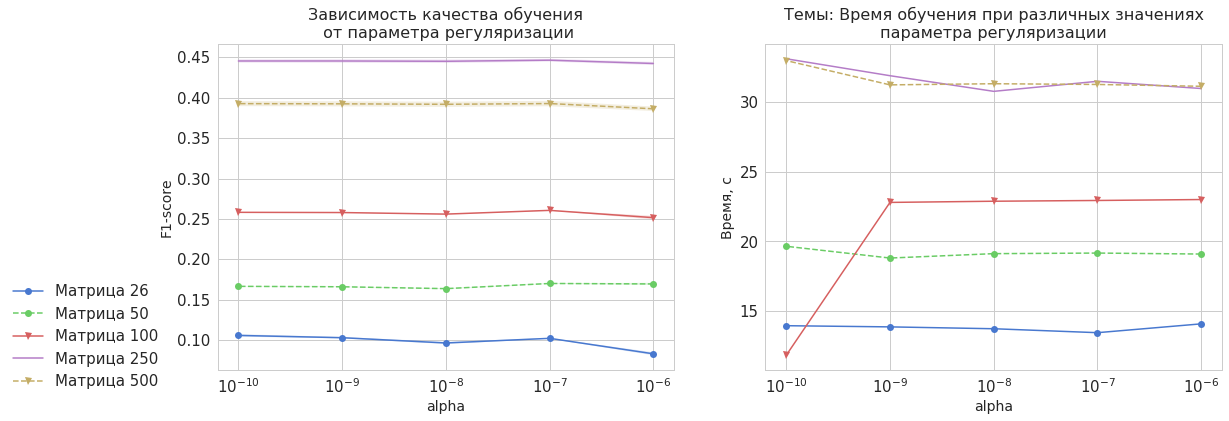

In [36]:
marks = ['o-','o--','v-','-','v--']
grids = ['gs-logistic-X_unigram_26.lda.pkl','gs-logistic-X_unigram_50.lda.pkl','gs-logistic-X_unigram_100.lda.pkl',\
         'gs-logistic-X_unigram_250.lda.pkl', 'gs-logistic-X_unigram_500.lda.pkl']
labels = ['26','50','100','250','500']
text = ["Зависимость качества обучения\n от параметра регуляризации",\
        "Время обучения при различных значениях\nпараметра регуляризации"]

def plot_cv(grids, labels, marks, title=text, log_scale=True): 
    '''
    Plotting model quality value with different regularization parameters
    '''
    plt.figure(figsize=(18,6))
    
    for i, grid in enumerate(grids):
        gs = load_data(grid)
        params = gs.cv_results_['params']
        p_name = list(params[0])[0]
        vals = [p[p_name] for p in params]
        scores = gs.cv_results_['mean_test_score']
        stds = gs.cv_results_['std_test_score']
        timing = gs.cv_results_['mean_fit_time']
        
        plt.subplot(1,2,1)
        plt.plot(vals, scores, marks[i], label='Матрица '+labels[i])
        plt.fill_between(vals, scores - stds, scores + stds, alpha=0.2, lw=0.1)
        plt.title(text[0], fontsize=16)
        plt.xlabel(p_name, fontsize=14)
        plt.ylabel('F1-score', fontsize=14)
        if log_scale:
            plt.xscale('log')
        plt.legend(loc='lower right', bbox_to_anchor=(-0.1,-0.1))
        
        plt.subplot(1,2,2)
        plt.plot(vals, timing, marks[i], label='Матрица '+labels[i])
        plt.title('Темы: ' + text[1], fontsize=16)
        plt.xlabel(p_name, fontsize=14)
        plt.ylabel('Время, с', fontsize=14)
        if log_scale:
            plt.xscale('log')

    plt.show()
    
plot_cv(grids, labels, marks)

In [37]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='hinge', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(6,11)]}

for name in names:
    X = load_data(path_to_models + name)
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs-hinge-' + name[:-4], k=3, verbose=1, n_jobs=1, normalizing=True)

Number of features: 26
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.2min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 42.3 s, sys: 0 ns, total: 42.3 s
Wall time: 6.71 s
Train score: 0.104 +/- 0.001
CV score: 0.103 +/- 0.002
Test score: 0.134

CPU times: user 8min 3s, sys: 0 ns, total: 8min 3s
Wall time: 1min 24s
Number of features: 50
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.6min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 59.8 s, sys: 0 ns, total: 59.8 s
Wall time: 9.42 s
Train score: 0.173 +/- 0.000
CV score: 0.170 +/- 0.001
Test score: 0.214

CPU times: user 10min 59s, sys: 0 ns, total: 10min 59s
Wall time: 1min 52s
Number of features: 100
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.9min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 1min 7s, sys: 0 ns, total: 1min 7s
Wall time: 11 s
Train score: 0.266 +/- 0.000
CV score: 0.260 +/- 0.000
Test score: 0.294

CPU times: user 13min 14s, sys: 0 ns, total: 13min 14s
Wall time: 2min 14s
Number of features: 250
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.6min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 1min 40s, sys: 0 ns, total: 1min 40s
Wall time: 16.2 s
Train score: 0.460 +/- 0.002
CV score: 0.446 +/- 0.002
Test score: 0.463

CPU times: user 18min 30s, sys: 0 ns, total: 18min 30s
Wall time: 3min 7s
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.4min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 1min 34s, sys: 0 ns, total: 1min 34s
Wall time: 15.4 s
Train score: 0.403 +/- 0.002
CV score: 0.393 +/- 0.004
Test score: 0.409

CPU times: user 17min 26s, sys: 0 ns, total: 17min 26s
Wall time: 2min 56s


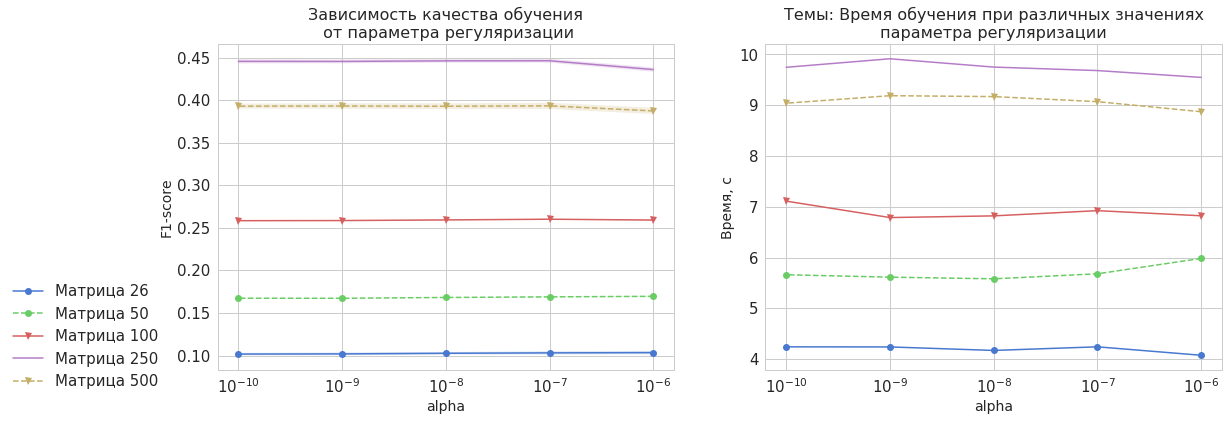

In [38]:
grids = ['gs-hinge-X_unigram_26.lda.pkl','gs-hinge-X_unigram_50.lda.pkl','gs-hinge-X_unigram_100.lda.pkl',\
         'gs-hinge-X_unigram_250.lda.pkl', 'gs-hinge-X_unigram_500.lda.pkl']

plot_cv(grids, labels, marks)

### Лучшая модель 
> **Число тем:** 250  
 **Классификатор:** SVM, alpha=1e-07  
 **Время обучения:** 15.4s  
 **F1-score:** 0.463

### (?)Коллокации

In [ ]:
names = ['collocation_26.lda', 'collocation_50.lda',
        'collocation_100.lda', 'collocation_250.lda',
        'collocation_500.lda']


# Загружаем частотную матрицу 
collocation_matrix = load_data('collocation-tfidf.matrix.pkl')

for name in names:
    lda = LdaModel.load(path_to_models + name)
    corpus = gensim.matutils.Sparse2Corpus(collocation_matrix.transpose())
    lda_corpus = lda[corpus]
    %time X_lda = gensim.matutils.corpus2csc(lda_corpus)
    pickling_data(path_to_models + 'X_' + name, X_lda.transpose())

## LDA & Word2Vec

In [6]:
path_to_lda = '/home/kulesh271828/arxiv/models/topic_modeling/'
#X_lda = load_data(path_to_lda + 'X_unigram_250.lda.pkl')

path_to_w2v = '/home/kulesh271828/arxiv/models/word2vec/'
model_sg = word2vec.KeyedVectors.load_word2vec_format(path_to_w2v + 'w2v_sg_500.bin', binary=True)

LDA model

In [112]:
%%time

documents = LazyCorpora(file, limit=n_corpora)
dictionary = gensim.corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

CPU times: user 22min 41s, sys: 13.7 s, total: 22min 54s
Wall time: 22min 54s


Сохраним словарь и корпус

In [113]:
dictionary.save('arxiv.dict')
gensim.corpora.MmCorpus.serialize('arxiv.mm', corpus)

Загрузка

In [42]:
corpus = gensim.corpora.MmCorpus('arxiv.mm')

In [50]:
categories = LazyCorpora(file, limit=n_corpora, column='primary_category')
cat_list = [cat for cat in categories]

In [9]:
%%time 

# Обучаем модель
#
model = LdaModel(corpus=corpus, id2word=dictionary, eval_every=None, num_topics=250, alpha='auto', eta='auto', \
                       iterations=100, chunksize=1000, passes=1)
# Сохранение
#
model.save(path_to_lda + 'unigram_250_id2word.lda')

CPU times: user 6h 3min 18s, sys: 9h 45min 10s, total: 15h 48min 29s
Wall time: 4h 28min 8s


In [7]:
model = LdaModel.load(path_to_lda + 'unigram_250_id2word.lda')

In [8]:
pd.DataFrame(model.show_topic(0, topn=10), columns=['Термин', '$P(термин~|~ тема)$'])

,Термин,$P(термин~|~ тема)$
0,group,0.356403
1,subgroup,0.053347
2,abelian,0.040650
3,automorphism,0.019977
4,automorphisms,0.014164
5,let,0.014041
6,non,0.010732
7,finite,0.009572
8,follow,0.008926
9,since,0.008843


In [9]:
%%time

topics = {}
n_voc = 499579
length = 1000

for t in range(250):
    topic = dict(model.show_topic(0, topn=length))
    topics[str(t)] = topic

CPU times: user 1min 6s, sys: 1min 9s, total: 2min 15s
Wall time: 2min 15s


Матрица документов

In [ ]:
%%time

#unigram_matrix = load_data('unigram_matrix_tfidf.pkl')
#corpus = gensim.matutils.Sparse2Corpus(unigram_matrix.transpose())

print("Corpus transformation...")
lda_corpus = model[corpus]
X_lda = gensim.matutils.corpus2csc(lda_corpus)
pickling_data(path_to_lda + 'X_lda_250@id2word', X_lda.transpose())

Corpus transformation...


In [116]:
#lda_corpus = model[corpus]
#X_lda = gensim.matutils.corpus2csc(lda_corpus)
#pickling_data(path_to_lda + 'X_lda_250@id2word', X_lda.transpose())

Загрузка матрицы

In [ ]:
X_lda_250 = load_data(path_to_lda + 'X_lda_250@id2word.pkl')
X_lda_250

### Вектор темы
[Комментарий]

In [28]:
n_features = 500
n_topics = 250
n_corpora = 163103

def topic_vector(w2v_model, topics, topic_name):
    '''
    Description
    '''
    vector = np.zeros(n_features)
    topic = topics[topic_name]
    words = topic.keys()
    
    for word in words:
        weigth = topic[word]
        vector = np.add(vector, weigth * w2v_model[word])
    return np.divide(vector, length)

def topic_matrix(w2v_model, topics):
    '''
    Description
    '''
    topics_name = topics.keys()
    topicsMatrix = np.zeros((n_topics, n_features), dtype='float32')
    
    for i, topic in enumerate(topics):
        topicVector = topic_vector(w2v_model, topics, topic)
        topicsMatrix[i] = topicVector
    return topicsMatrix

def document_vector(w2v_model, topics, X_lda):
    '''
    Description
    '''
    X_topics = sparse.csr_matrix(topic_matrix(w2v_model, topics))
    docMatrix = np.dot(X_lda, X_topics)
    return docMatrix

In [ ]:
%%time

X = document_vector(model_sg, topics, X_lda_250)

In [ ]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='hinge', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(8,11)]}

print("Number of features: %d" % X.shape[1])
%time modeling(clf, parameters, X, np.array(cat_list), 'gs-logistic-lda@w2v_sg', k=3, verbose=1, n_jobs=1, normalizing=True)

## Источники
1. @MelLain, @vovapolu, @romovpa. [Topic Modeling with BigARTM](https://github.com/cimsweb/bigartm-book)  
2. @edimser. [VisARTM - visualizer for BigARTM](https://github.com/bigartm/visartm)  
- @olavurmortensen. [lda_training_tips.ipynb](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/lda_training_tips.ipynb)
- @Surfingbirg. Вероятностные модели: от наивного Байеса к LDA, [часть 1](https://habrahabr.ru/company/surfingbird/blog/228249/), [часть 2](https://habrahabr.ru/company/surfingbird/blog/230103/)  
- models.ldamulticore – [parallelized Latent Dirichlet Allocation](http://radimrehurek.com/gensim/models/ldamulticore.html#module-gensim.models.ldamulticore)
- E. Chen. [Introduction to LDA](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation//)
- C. Карпович. [Многозначная классификация текстовых документов с использованием вероятностного тематического моделирования ml-PLSI](https://docviewer.yandex.by/view/431087183/?*=ZMDgX%2FVizHQyIKC3IhATEkXoEN97InVybCI6Imh0dHA6Ly9wcm9jZWVkaW5ncy5zcGlpcmFzLm53LnJ1L29qcy9pbmRleC5waHAvc3AvYXJ0aWNsZS9kb3dubG9hZC8zMzU5LzE5NDIiLCJ0aXRsZSI6IjE5NDIiLCJ1aWQiOiI0MzEwODcxODMiLCJ5dSI6Ijg1NjA1MjY0MzE0Njk0NjYxNDAiLCJub2lmcmFtZSI6dHJ1ZSwidHMiOjE0OTI5Mzg2NjgxNjF9&page=1&lang=ru)  
- Антон Коршунов, Андрей Гомзин. [Тематическое моделирование текстов на естественном языке](http://www.ispras.ru/proceedings/docs/2012/23/isp_23_2012_215.pdf)  
- К. Маслинский. Автоматическое определение тематики, [часть 1](http://maslinsky.spb.ru/courses/cmta2013/slides/04topic.pdf), [часть 2](http://maslinsky.spb.ru/courses/cmta2013/slides/04tm.pdf)
- К.В.Воронцов. [Лекции по вероятностным тематическим моделям](http://www.machinelearning.ru/wiki/images/2/22/Voron-2013-ptm.pdf)  
- Лекция по латентному размещению Дирихле в рамках спецкурса БММО [ссылка](http://www.machinelearning.ru/wiki/images/8/82/BMMO11_14.pdf)  
- Thomas Hofmann [Probabilistic Latent Semantic Analysis ](https://arxiv.org/ftp/arxiv/papers/1301/1301.6705.pdf)
- David M. Blei, Andrew Ng, Michael Jordan. [Latent Dirichlet allocation](http://jmlr.org/papers/volume3/blei03a/blei03a.pdf) // Journal of Machine Learning Research (3) 2003 pp. 993-1022.  
- David M. Blei. [Introduction to Probabilistic Topic Models](http://adiwijaya.staff.telkomuniversity.ac.id/files/2014/02/Blei-Introduction-to-Probabilistic-Topic-Models.pdf)  
- David M. Blei, John D. Lafferty. [Correlated Topic Models](http://www.cs.columbia.edu/~blei/papers/BleiLafferty2006.pdf)
-  Hoffman, Blei, Bach. [Online learning for Latent Dirichlet Allocation](https://mimno.infosci.cornell.edu/info6150/readings/HoffmanBleiBach2010b.pdf)  
- Y. Teh, M. Jordan, M. Beal, D. Blei. Hierarchical Dirichlet processes // Journal of the American
Statistical Association, V. 101, 2006, pp. 1566–1581.  
- С. Воронов. [Фильтрация и тематическое моделирование коллекции научных документов](http://www.machinelearning.ru/wiki/images/8/84/Voronov2014Classification.pdf)  
- [автоматическое определение кол-ва тем] [The Nested Chinese Restaurant Process and Bayesian Nonparametric Inference of Topic Hierarchies](https://cocosci.berkeley.edu/tom/papers/ncrp.pdf)  
- Yee Whye Teh. A [Tutorial](http://mlg.eng.cam.ac.uk/tutorials/07/ywt.pdf) on Dirichlet Processes and Hierarchical Dirichlet Processes